In [1]:
#Imports
import gym
import tensorflow as tf
import gc
import os
import random

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from collections import deque
import numpy as np

####### Space Invaders
load_model           = True
perform_learning     = True
environment_name     = "SpaceInvadersNoFrameskip-v4"
discrete_actions     = 6
saver_path           = "./models/"
saver_file_name      = "space_invaders_three_layers_q_rl"
height               = 210
width                = 160
channels             = 1
frames_captured      = 4
max_learning_rate    = .00000001    # 2 x 10^-7   .0000001 seems to be the point where it will stop forming a bias to only do one thing
min_learning_rate    = .000000003  # 5 x 10^-9   .0000001 seems to be the point where it will stop forming a bias to only do one thing
dropout_keep_prob    = 1.0
negative_retrain_attempts = 10

max_steps_until_done = 2000000  #1000*3000
n_epochs             = 3
use_random_every_x_epoch = 5
discount_decay_rate_range = [0.97, 0.99]
frame_limit          = 2001
max_score            = 5.0
death_reward_range   = [-24.0, -18.0]
death_reward_frames_delay = 44 #24 when capturing every fifth frame in the buffer.   45 when capturing every third
maximum_negative_training_batches = 350   #150 works when capturing every fifth frame - maybe use 250 for every third


####### Pitfall
# environment_name     = "Pitfall-v0"
# discrete_actions     = 18
# load_model           = False
# saver_file           = "./models/pitfall_rl"
# height               = 210
# width                = 160
# channels             = 1
# frames_captured      = 5
# learning_rate        =.00001
# n_epochs             = 11
# use_random_every_x_epoch = 5
# discount_decay_rate  = 0.95
# frame_limit          = 1000

####### River Raid
# environment_name     = "Riverraid-v0"
# discrete_actions     = 18
# load_model           = True
# saver_file           = "./models/pitfall_rl"
# height               = 210
# width                = 160
# channels             = 1
# frames_captured      = 5
# learning_rate        =.00001
# n_epochs             = 501
# use_random_every_x_epoch = 5
# discount_decay_rate  = 0.95
# frame_limit          = 1000


def preprocess_observation(obs):
    img = obs
    img = img.mean(axis=2) # to greyscale
    #img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    img = img / 256.0  # normalize from 0 to 1.
    return img

def show_observation(image, title="Image"):
    plt.figure(figsize=(11, 7))
    plt.subplot(121)
    plt.title(title)
    plt.imshow(image, cmap="gray") #cmap="gray"
    plt.axis("off")
    plt.show()

def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum( np.exp(x))
    return ex/sum_ex
    
env = gym.make(environment_name)
observation = env.reset()
print("obs.shape: {}".format(observation.shape)) #obs.shape: (210, 160, 3)
print("env.action_space: {}".format(env.action_space)) #env.action_space: Discrete(9)

for step_counter in range(102):
    observation, reward_float, done_bool, info_dict = env.step(1)
    obs_greyscale = preprocess_observation(observation)

#show_observation(observation)
#show_observation(obs_greyscale)
    
print (softmax([1,-2,3]))

test_softmax = softmax([4.3210541e-25, 5.4929095e-33, 5.3535387e-02, 1.2303401e-42, 9.4646466e-01, 1.9473004e-27])
print ("test_softmax: {}".format(test_softmax))

multinomial_action_array = np.random.multinomial(1, test_softmax)
print ("multinomial_action_array: {}".format(multinomial_action_array))



obs.shape: (210, 160, 3)
env.action_space: Discrete(6)
[0.11849965 0.00589975 0.8756006 ]
test_softmax: [0.13103449 0.13103449 0.13824064 0.13103449 0.33762142 0.13103449]
multinomial_action_array: [0 0 0 1 0 0]


In [2]:
from random import randint

eps_min = 0.00
eps_max = 0.5
eps_decay_steps = 25000

def helper_discount_rewards(rewards, discount_rate, begin_index, end_index):
    '''
    Takes in rewards and applies discount rate
    '''
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step_counter in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step_counter] + cumulative_rewards * discount_rate
        discounted_rewards[step_counter] = cumulative_rewards
    
    reward_mean = discounted_rewards.mean()
    reward_std = discounted_rewards.std()
        
    #return discounted_rewards
    return [(discounted_reward - reward_mean)/reward_std for discounted_reward in discounted_rewards]
    #return [(discounted_reward - reward_mean)/(reward_mean*.75) for discounted_reward in discounted_rewards]

def action_to_one_hot(action, possible_action_count):
    return_array = np.zeros(possible_action_count)
    action_int = int(action)
    return_array[action_int] = 1.0
    return return_array

def getRewardArrays(actions, discounted_rewards, possible_action_count):
    reward_arrays = []   
    for this_action, this_reward in zip(actions, discounted_rewards):
        this_value = action_to_one_hot(this_action, possible_action_count)
        this_value = this_value * this_reward
        reward_arrays.append(this_value)
        
    return reward_arrays

def getRewardAverages(actions, discounted_rewards, possible_action_count):
    reward_arrays = getRewardArrays(actions, discounted_rewards, possible_action_count)     
    return np.mean(reward_arrays, axis=0)

def weightRewardAveragesToAverageZero(actions, rewardArrays, possible_action_count):
    positive_sums = np.zeros(possible_action_count)
    negative_sums = np.zeros(possible_action_count)
    
    positive_counts = np.zeros(possible_action_count)
    negative_counts = np.zeros(possible_action_count)
    
    for i in range(0, possible_action_count):
        positiveSum = 0
        negativeSum = 0
        positiveCount = 0
        negativeCount = 0
        for rewardArray in rewardArrays:
            if rewardArray[i] >= 0:
                positiveSum = positiveSum + rewardArray[i]
                positiveCount = positiveCount + 1
            else:
                negativeSum = negativeSum + rewardArray[i]
                negativeCount = negativeCount + 1
    
        positive_sums[i] = positiveSum
        negative_sums[i] = negativeSum
        positive_counts[i] = positiveCount
        negative_counts[i] = negativeCount
        
#     print("positive_sums: {}".format(positive_sums));
#     print("negative_sums: {}".format(negative_sums));
#     print("positive_counts: {}".format(positive_counts));
#     print("negative_counts: {}".format(negative_counts));

    for i in range(0, possible_action_count):
        makeupTotal = positive_sums[i] + negative_sums[i]
        for rewardArray in rewardArrays:
            if makeupTotal > 0 and rewardArray[i] < 0:
                rewardArray[i] = rewardArray[i] - makeupTotal/negative_counts[i]
            elif makeupTotal < 0 and rewardArray[i] > 0:
                rewardArray[i] = rewardArray[i] - makeupTotal/positive_counts[i]
                
    return rewardArrays


def get_average_logits (logits_list, discounted_rewards):
    logit_sums = np.zeros(len(logits_list[0][0]))
    logit_sums_counter = np.ones(len(logits_list[0][0]))

    for this_logit, this_reward in zip(logits_list, discounted_rewards):
        temp_array = np.zeros(len(logits_list[0][0]))
        temp_counter_array = np.zeros(len(logits_list[0][0]))
        
        action = np.argmax(this_logit)
        temp_array[action] = this_logit[0][action]
        logit_sums = logit_sums + temp_array*this_reward
        temp_counter_array[action] = 1
        logit_sums_counter = logit_sums_counter + temp_counter_array
        
    return (logit_sums/logit_sums_counter)

# print("action_to_one_hot(3, 9): " + str(action_to_one_hot(3.0, 9)))
# print("action_to_one_hot(9, 9): " + str(action_to_one_hot(8, 9)))
#print(get_average_logits(all_logits, discounted_rewards))
#print(all_logits)

In [3]:
n_inputs  = discrete_actions
n_outputs = discrete_actions
n_hidden1 = 512
n_hidden2 = 256

tf.reset_default_graph()

global_step = tf.Variable(0, name='global_step', trainable=False)

#with tf.name_scope("inputs"):
tf_input_frame = tf.placeholder(tf.float32, shape=(None, height*frames_captured, width, channels))
tf_input_value = tf.placeholder(tf.float32, shape=(None, n_inputs))
tf_train_index = tf.placeholder(tf.int32)
tf_input_learning_rate = tf.placeholder(tf.float32)
tf_dropout_keep_prob = tf.placeholder(tf.float32)
tf_reward = tf.placeholder(tf.float32)
tf_q_input = tf.placeholder(tf.float32, shape=(None, 1))
    
initializer = tf.contrib.slim.variance_scaling_initializer(factor=1.0 / np.sqrt(3.0), mode='FAN_IN', uniform=True)

convs   = [32,64,64]
kerns   = [8,4,3]
strides = [4,2,1]

pads    = 'valid'
activ   = tf.nn.elu

# Policy Network
conv1 = tf.layers.conv2d(
        inputs = tf_input_frame,
        filters = convs[0],
        kernel_size = kerns[0],
        strides = strides[0],
        padding = pads,
        activation = activ,
        name='conv1')

conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters = convs[1],
        kernel_size = kerns[1],
        strides = strides[1],
        padding = pads,
        activation = activ,
        name='conv2')

conv3 = tf.layers.conv2d(
        inputs=conv2,
        filters = convs[2],
        kernel_size = kerns[2],
        strides = strides[2],
        padding = pads,
        activation = activ,
        name='conv3')

flat = tf.layers.flatten(conv3)

hidden1 = tf.layers.dense(flat,    n_hidden1, activation=activ, name="hidden1", kernel_initializer=initializer)
hidden1_drop = tf.nn.dropout(hidden1, tf_dropout_keep_prob)
hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=activ, name="hidden2", kernel_initializer=initializer)

q_predicted = tf.layers.dense(inputs=hidden2, units=1, name="output_q", activation=None)
logits = tf.layers.dense(inputs=hidden2, units=n_outputs, name="output", activation=None)

# only train on the action taken.  Ignore the rest since we really don't have insightful advice for the other actions.
single_logit = logits[:,tf_train_index]

#loss = tf.reduce_mean(tf.square(logits-tf_input_value))
loss = tf.reduce_sum(tf.square(single_logit-tf_reward))

optimizer = tf.train.AdamOptimizer(tf_input_learning_rate)
training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=3)


In [4]:
env = gym.make(environment_name)

def get_concatenated_frames(frames, end_index, num_frames_to_concatenate):
    concatenated_frames = frames[:,:,end_index-1]

    for j in range(1,num_frames_to_concatenate,1):
        if end_index-j <= 1:
            this_frame = frames[:,:,0]
        elif j >= num_frames:
            this_frame = frames[:,:,end_index-1]
        else:
            this_frame = frames[:,:,end_index-1-j]
            
        concatenated_frames = np.append(concatenated_frames, this_frame, axis=0)
    return concatenated_frames

with tf.Session() as sess:
    if load_model:
        print("Loading existing model before training: {}".format(saver_file_name))
        #saver.restore(sess, tf.train.latest_checkpoint(saver_file))
        
        ckpt = tf.train.get_checkpoint_state(saver_path)
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        saver.restore(sess, os.path.join(saver_path, ckpt_name))
    else:
        print("Creating new model before training: {}".format(saver_file_name))
        sess.run(init)
    
    step = global_step.eval(session=sess)
    
    for epoch in range(n_epochs):  #play n_epochs games
        if step > max_steps_until_done:
            print("Max Steps reached: step: {}, max steps: {}".format(step, max_steps_until_done))
            break
                
        observation = env.reset()
        temp_lives = 3
        score = 0.0
        total_rewards = 0.0
        frames = np.empty([height, width, 0])
        actions = np.empty([0])
        rewards = np.empty([0])
        all_logits = []
        all_training_logits = []
        punish_frames = []
        default_input_q = np.reshape([0.0], (1,1))
            
        #get the first frame
        input_value = 0  #set an initial input value
        observation, reward_float, done_bool, info_dict = env.step(input_value)  #run one to get frames that show enemy fire
        
        obs_greyscale = preprocess_observation(observation)
        obs_greyscale_reshape = np.reshape(obs_greyscale, (height,width,1))
        frames = np.append(frames, obs_greyscale_reshape, axis=2)
        actions = np.append(actions, input_value)
        last_action_step = 0
        decision_step_counter = 0

        game_step_counter = 0
        action_from_ai_epsilon_greedy = 0
        points_at_death = []
        
        gc.disable()
        while True:
            num_frames = np.ma.size(frames, axis=2)                     
            concatenated_frames = get_concatenated_frames(frames, num_frames, frames_captured)
            concatenated_frames_reshaped = np.reshape(concatenated_frames, (1, height*frames_captured, width, 1))
            
            #use the input value from the AI
            temp_input = np.zeros(discrete_actions) #[0, 0, 0, ...]
            temp_input[action_from_ai_epsilon_greedy] = 1
            temp_input_reshaped = np.reshape(temp_input, (1, len(temp_input)))
            
            
            #tf_dropout_keep_prob: 1.0,
            feed_dict = {tf_input_frame : concatenated_frames_reshaped, 
                         tf_input_value : temp_input_reshaped,
                         tf_input_learning_rate: 0.0,
                         tf_dropout_keep_prob: 1.0,
                         tf_reward: 0.0,
                         tf_q_input: default_input_q}
            logits_out = sess.run([logits], feed_dict=feed_dict)

            all_logits.append(logits_out[0][0])
            
            #if global_step % 5 == 0:  #only allow a change of direction every 5 steps.  
            action_from_ai_logits_argmax = np.argmax(logits_out[0])
    
            positive_logits = logits_out[0] + abs(np.amin(logits_out[0]))
            softmax_logits = softmax(positive_logits / np.amax(positive_logits))

            try:
                multinomial_action_array = np.random.multinomial(1, softmax_logits[0])
                action_from_multinomial_action = np.argmax(multinomial_action_array)
#                print ("multinomial_action_array: {}".format(multinomial_action_array))
            except ValueError:
                #I have no idea why this occassionally errors out.
                action_from_multinomial_action = np.argmax(softmax_logits)
                print ("multinomial error, using action {}".format(action_from_multinomial_action))
                continue
                
#            print ("action_from_multinomial_action: {}".format(action_from_multinomial_action))
        
            # decide which action to use
            #only train even frames for consistency between frames with enemy vs friendly fire.
            #perform logic here for consistency between what is trained and what actions are taken
#            if i % 2 != 0:
            if epoch % use_random_every_x_epoch != 0:
                if game_step_counter == 0:
                    print("Using strict AI actions")
                action_from_ai_epsilon_greedy = action_from_ai_logits_argmax  #do what the AI says
            else:
#                print("Using probability-based actions")
                if step % 2 == 0:
                    action_from_ai_epsilon_greedy = action_from_multinomial_action  #use probability-based action
                else:
                    action_from_ai_epsilon_greedy = action_from_ai_logits_argmax 
            
            this_reward_for_set = 0
            
            #run the next step given the input from the logits
            observation, reward_float, done_bool, info_dict = env.step(action_from_ai_epsilon_greedy)
            score = score + reward_float
            if reward_float > max_score:
                this_reward_for_set = this_reward_for_set + max_score
                #rewards = np.append(rewards, max_score)
                total_rewards = total_rewards + max_score
            else:
                this_reward_for_set = this_reward_for_set + reward_float
                #rewards = np.append(rewards, reward_float)
                total_rewards = total_rewards + reward_float
                
            observation, reward_float, done_bool, info_dict = env.step(action_from_ai_epsilon_greedy)
            score = score + reward_float
            if reward_float > max_score:
                this_reward_for_set = this_reward_for_set + max_score
                #rewards = np.append(rewards, max_score)
                total_rewards = total_rewards + max_score
            else:
                this_reward_for_set = this_reward_for_set + reward_float
                #rewards = np.append(rewards, reward_float)
                total_rewards = total_rewards + reward_float
            
            observation, reward_float, done_bool, info_dict = env.step(action_from_ai_epsilon_greedy)
            score = score + reward_float
            if reward_float > max_score:
                this_reward_for_set = this_reward_for_set + max_score
                #rewards = np.append(rewards, max_score)
                total_rewards = total_rewards + max_score
            else:
                this_reward_for_set = this_reward_for_set + reward_float
                #rewards = np.append(rewards, reward_float)
                total_rewards = total_rewards + reward_float
            
#             observation, reward_float, done_bool, info_dict = env.step(action_from_ai_epsilon_greedy)
#             score = score + reward_float
#             if reward_float > max_score:
#                 this_reward_for_set = this_reward_for_set + max_score
#                 #rewards = np.append(rewards, max_score)
#                 total_rewards = total_rewards + max_score
#             else:
#                 this_reward_for_set = this_reward_for_set + reward_float
#                 #rewards = np.append(rewards, reward_float)
#                 total_rewards = total_rewards + reward_float
                
#             observation, reward_float, done_bool, info_dict = env.step(action_from_ai_epsilon_greedy)
#             score = score + reward_float
#             if reward_float > max_score:
#                 this_reward_for_set = this_reward_for_set + max_score
#                 #rewards = np.append(rewards, max_score)
#                 total_rewards = total_rewards + max_score
#             else:
#                 this_reward_for_set = this_reward_for_set + reward_float
#                 #rewards = np.append(rewards, reward_float)
#                 total_rewards = total_rewards + reward_float
                
            rewards = np.append(rewards, this_reward_for_set)
            
#            if step % 2 != 0:
            env.render()  #display the current frame.
                
            #add this frame to our frame buffer
            obs_greyscale = preprocess_observation(observation)
            obs_greyscale_reshape = np.reshape(obs_greyscale, (height,width,1))
            frames = np.append(frames, obs_greyscale_reshape, axis=2)
            
            actions = np.append(actions, action_from_ai_epsilon_greedy)
            
            lives = info_dict['ale.lives']

            if done_bool:
                punish_frames.append(len(rewards) - death_reward_frames_delay)
                print("Death at frame {}. Score: {}. Total Rewards: {}".format(len(rewards), score, total_rewards))
                points_at_death.append(total_rewards)
                break
                
            if game_step_counter > frame_limit:
                break
                
            if lives != temp_lives:  #we lost a life.  consider this game over.
                #print("Lost a life.  Current lives: {}".format(lives))
                temp_lives = lives
                if len(rewards) > death_reward_frames_delay:
                    punish_frames.append(len(rewards) - death_reward_frames_delay)
                    print("Death at frame {}. Score: {}. Total Rewards: {}".format(len(rewards), score, total_rewards))
                    points_at_death.append(total_rewards)

            decision_step_counter += 1
            game_step_counter += 1
            step += 1
        gc.enable()
        
        # only train that last 700 frames
        original_len = len(actions)
        print("original_len: {}".format(original_len))
        print("original punish_frames: {}".format(punish_frames))
        
        if original_len > 800:
            frames = frames[:,:,-800:]
            rewards = rewards[-800:]
            actions = actions[-800:]
            all_logits = all_logits[-800:]
            #punish_frames = punish_frames - (original_len-700)
            punish_frames[:] = [x - (original_len-800) for x in punish_frames]
        
        if perform_learning:
            if epoch % 20 == 0 and epoch > 0:
                print("Saving model at epoch {}. score: {}, file: {}".format(epoch, score, saver_file_name))
                saver.save(sess, os.path.join(saver_path, saver_file_name), global_step=step)

            num_frames = np.ma.size(frames, axis=2)
            frames_to_skip_begin = 0
            frames_to_skip_end  = 0  #number of frames between pacman being eaten and game reset

            #train three times using different (random) values for discounted rewards and death punishments
            for x in range(1,2):
                #punish death
                temp_points = 0

                death_penalty = random.uniform(death_reward_range[0], death_reward_range[1])

                for this_frame, this_points in zip(punish_frames, points_at_death):
                    if this_frame < 0 or this_frame > len(rewards):
                        continue
                    rewards[this_frame] = death_penalty
                    print("Death reward at frame {}: {}".format(this_frame, rewards[this_frame]))

                discount_decay_rate = random.uniform(discount_decay_rate_range[0], discount_decay_rate_range[1])
                discounted_rewards = helper_discount_rewards(rewards, discount_decay_rate, frames_to_skip_begin, num_frames) #-1-frames_to_skip_end

                positive_display_actions = np.zeros(discrete_actions)
                negative_display_actions = np.zeros(discrete_actions)
                ai_training_actions = np.zeros(discrete_actions)
                loss_out_sum = 0.0
                frames_taught = 0.000000001

                reward_frame_counter = 0
                punish_frame_counter = 0

                frames_to_train = np.arange(num_frames-2-frames_to_skip_end)
#                np.random.shuffle(frames_to_train)  ###########################

                skipped_negative_training_batches = 0

                disagreement_counter = 0
                for i in range(frames_to_skip_begin, num_frames-2-frames_to_skip_end):   #skip the first frames
                    this_random_frame_index = frames_to_train[i]

                    concatenated_frames = get_concatenated_frames(frames, this_random_frame_index, frames_captured)
                    concatenated_frames_reshaped = np.reshape(concatenated_frames, (1, height*frames_captured, width, 1))

                    action_taken_one_hot = action_to_one_hot(actions[this_random_frame_index], n_outputs)

                    reward_for_frame = discounted_rewards[this_random_frame_index]
                    
                    #print("reward for frame {} :{}. frame array: {}".format(this_random_frame_index, reward_for_frame, reward_arrays[this_random_frame_index+1]) )
                    max_logit                 = np.amax(all_logits[this_random_frame_index])
                    second_max_logit_index = np.argsort(all_logits[this_random_frame_index])[len(all_logits[this_random_frame_index])-2]
                    second_max_logit =                  all_logits[this_random_frame_index][second_max_logit_index]
                    min_logit =                 np.amin(all_logits[this_random_frame_index])
                    average_logit =          np.average(all_logits[this_random_frame_index])
                    action_logit =                      all_logits[this_random_frame_index][int(actions[this_random_frame_index])]
                    
#                     print("original action: {}: original reward: {}, logits: {}".format(actions[this_random_frame_index], reward_for_frame, all_logits[this_random_frame_index]))
#                     print("second largest logit: {}".format(second_max_logit))
                    
                    if reward_for_frame > 0.0:
                        positive_display_actions = np.add(positive_display_actions, action_taken_one_hot)
                        reward_for_frame = reward_for_frame + action_logit
                        #The ai took a good action.  keep reward the same.
                    else:
                        negative_display_actions = np.add(negative_display_actions, action_taken_one_hot)
                        #TODO - need to address action logit vs second max logit
                        reward_for_frame = reward_for_frame + second_max_logit

                    #add current reward to the average of the logits 
                    #reward_for_frame = reward_for_frame + average_logit
#                    reward_for_frame = reward_for_frame + action_logit
#                    print("reward for frame: {}, max_logit: {}, min_logit: {}".format(reward_for_frame, max_logit, min_logit))
            
                    action_taken_one_hot_reshaped = np.reshape(action_taken_one_hot, (1, len(action_taken_one_hot)))

                    learning_rate = max_learning_rate - step/max_steps_until_done*(max_learning_rate-min_learning_rate)

                    input_q = np.reshape([reward_for_frame], (1,1))

                    feed_dict = {tf_input_frame : concatenated_frames_reshaped, 
                                 tf_input_value : action_taken_one_hot_reshaped,
                                 tf_input_learning_rate: learning_rate,
                                 tf_dropout_keep_prob: 1.0,  ######################### 
                                 tf_reward: reward_for_frame,
                                 tf_q_input: input_q,
                                 tf_train_index: actions[this_random_frame_index]}
                    loss_out, _, training_logits_out = sess.run([loss, training_op, logits], feed_dict=feed_dict)
                    
                    all_training_logits.append(training_logits_out[0])
                    
                    if np.argmax(all_training_logits[i]) != np.argmax(all_logits[i]):
                        disagreement_counter += 1
                        
#                     force_change_counter = 0
#                     if discounted_rewards[i] < -2.5:
#                         print("forcing new decision.  frame: {}, action: {}: reward: {}".format(i, actions[this_random_frame_index], round(discounted_rewards[i], 2) ))
#                         while np.argmax(all_training_logits[i]) == np.argmax(all_logits[i]):
#                             loss_out, _, training_logits_out = sess.run([loss, training_op, logits], feed_dict=feed_dict)
#                             all_training_logits[len(all_training_logits)-1] = training_logits_out[0]
#                             force_change_counter += 1
#                             if force_change_counter >= negative_retrain_attempts:
#                                 break
#                         print("forced new decision in {} steps. New decision: {}".format(force_change_counter, all_training_logits[i]))

                    
                    frames_taught = frames_taught + 1
                    loss_out_sum += abs(loss_out)

                    action_from_training = np.argmax(training_logits_out[0])
                    action_from_training_one_hot = action_to_one_hot(action_from_training, n_outputs)
                    ai_training_actions = np.add(ai_training_actions, action_from_training_one_hot)

                print("Epoch: " + str(epoch) + ", frames: " + str(num_frames) + ", score: " + str(score) + ", avg loss: " + str(loss_out_sum/frames_taught) + ", learning_rate: " + str(learning_rate) + ", step: " + str(step) + ", discount_decay_rate: " + str(discount_decay_rate) + ", death_penalty: " + str(death_penalty) + ", skipped_negative_training_batches: " + str(skipped_negative_training_batches))
                print("actions trained (positive):   {}".format(positive_display_actions))
                print("actions trained (negative):   {}".format(negative_display_actions))
                print("actions trained (total):      {}".format(positive_display_actions+negative_display_actions))
                print("actions out while training:   {}".format(ai_training_actions))
                print("training disagreements with runthrough:   {}".format(disagreement_counter))
                
                print("")


Loading existing model before training: space_invaders_three_layers_q_rl
INFO:tensorflow:Restoring parameters from ./models/space_invaders_three_layers_q_rl-1540974
Death at frame 222. Score: 35.0. Total Rewards: 20.0
Death at frame 488. Score: 65.0. Total Rewards: 40.0
Death at frame 713. Score: 115.0. Total Rewards: 60.0
original_len: 714
original punish_frames: [178, 444, 669]
Death reward at frame 178: -19.008016728857598
Death reward at frame 444: -19.008016728857598
Death reward at frame 669: -19.008016728857598
Epoch: 0, frames: 714, score: 115.0, avg loss: 1.2777961909408524, learning_rate: 5.3442545e-09, step: 1330213, discount_decay_rate: 0.9775019685853136, death_penalty: -19.008016728857598, skipped_negative_training_batches: 0
actions trained (positive):   [ 64.  36.  24.  35. 237. 121.]
actions trained (negative):   [12. 17. 10.  8. 96. 52.]
actions trained (total):      [ 76.  53.  34.  43. 333. 173.]
actions out while training:   [ 43.   0.   0.   0. 472. 197.]
training

discounted reward at frame 501: 0.42
original logits at frame 501: 4 [-0.59671634 -0.5815074  -0.80489016 -0.63032156 -0.2877932  -0.42995876]


<IPython.core.display.Javascript object>


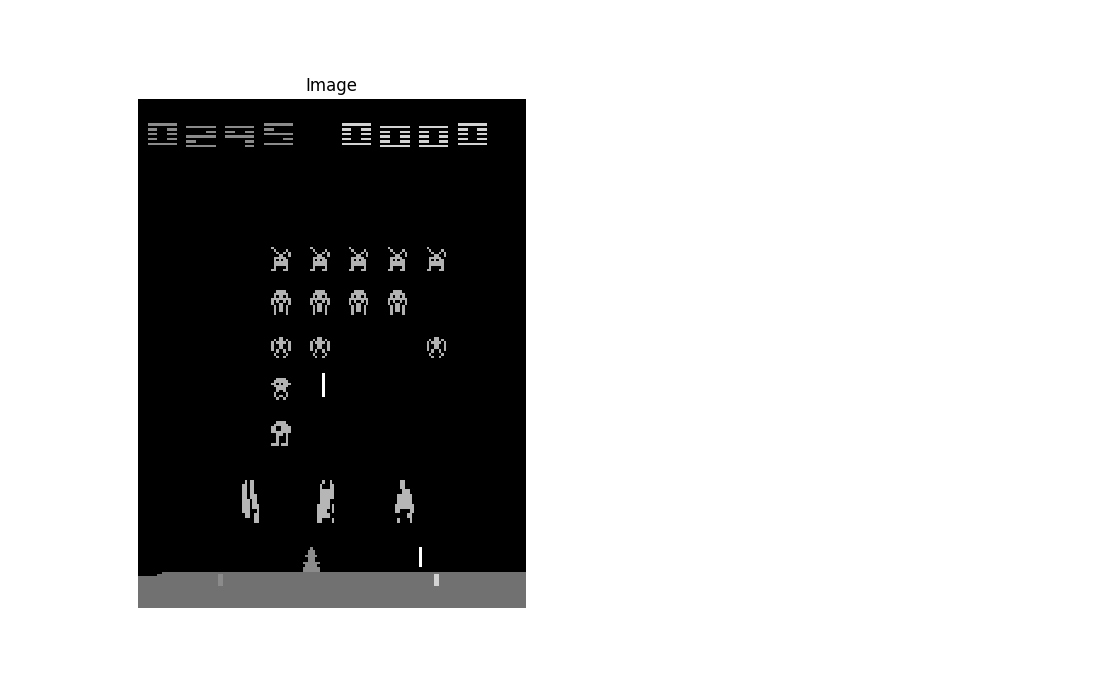

In [12]:

frame_to_display = 501
print("discounted reward at frame {}: {}".format(frame_to_display, round(discounted_rewards[frame_to_display], 2)))
print("original logits at frame {}: {} {}".format(frame_to_display, np.argmax(all_logits[frame_to_display]), all_logits[frame_to_display]))

# print("training logits at frame {}: {} {}".format(frame_to_display, np.argmax(all_training_logits[frame_to_display]), all_training_logits[frame_to_display]))
# print("action at frame {}: {}".format(frame_to_display, actions[frame_to_display]))


concatenated_frames = get_concatenated_frames(frames, frame_to_display, 1)


show_observation(concatenated_frames)

In [7]:

counter = 0
for this_reward in discounted_rewards:
    #print("{}: action: {}-{}, {}, {}".format(counter, np.argmax(all_logits[counter]), actions[counter], this_reward, all_logits[counter]))
    #frame: action-action, reward, logits
    
    print("{}: action: {}, reward: {}, max_logit: {}".format(counter, np.argmax(all_logits[counter]), this_reward, all_logits[counter][np.argmax(all_logits[counter])]  ))
    print("   {}".format(all_logits[counter]))
          
    counter += 1
        

0: action: 5, reward: 0.0048621843565114075, max_logit: -0.3856288492679596
   [-0.83279103 -1.5346766  -0.55471987 -0.6039569  -1.5364798  -0.38562885]
1: action: 5, reward: 0.01677601178773602, max_logit: -0.338278204202652
   [-0.83193535 -1.5325146  -0.55192125 -0.59031963 -1.5110704  -0.3382782 ]
2: action: 5, reward: 0.028952214224027436, max_logit: -0.23312075436115265
   [-0.78073126 -1.4982094  -0.544135   -0.51853174 -1.4759617  -0.23312075]
3: action: 5, reward: 0.04139656987928716, max_logit: -0.2656208872795105
   [-0.79434454 -1.5164821  -0.5470319  -0.5372205  -1.4793471  -0.2656209 ]
4: action: 5, reward: 0.05411498421946151, max_logit: -0.21401996910572052
   [-0.77506155 -1.4926503  -0.5322798  -0.5096706  -1.4693686  -0.21401997]
5: action: 5, reward: 0.06711349276497908, max_logit: -0.23481632769107819
   [-0.7806994  -1.506119   -0.53544307 -0.5190232  -1.476238   -0.23481633]
6: action: 5, reward: 0.08039826395490529, max_logit: -0.21264906227588654
   [-0.7707287

559: action: 5, reward: 0.4526546172702564, max_logit: -5.120464324951172
   [-5.7163043 -5.8490934 -6.046736  -6.820213  -5.7296753 -5.1204643]
560: action: 5, reward: 0.4744300565581946, max_logit: -5.115886688232422
   [-5.7185583 -5.8459635 -6.027354  -6.820499  -5.720725  -5.1158867]
561: action: 5, reward: 0.4966850504667184, max_logit: -5.254837989807129
   [-5.8500257 -5.947565  -6.1393743 -6.95493   -5.882332  -5.254838 ]
562: action: 5, reward: 0.5194301600977687, max_logit: -5.298998832702637
   [-5.927488  -5.997564  -6.212462  -7.0416145 -6.0006194 -5.298999 ]
563: action: 5, reward: 0.542676179137583, max_logit: -5.34075403213501
   [-5.9813666 -6.0769463 -6.268131  -7.115984  -6.071569  -5.340754 ]
564: action: 5, reward: 0.5664341389788369, max_logit: -5.397181987762451
   [-6.093375  -6.2297416 -6.3430767 -7.2120705 -6.1969857 -5.397182 ]
565: action: 5, reward: 0.5907153139555884, max_logit: -5.2730278968811035
   [-5.9919515 -6.1368055 -6.251398  -7.1161385 -6.078816

In [8]:
for i in range(0, len(all_logits)):
    print("{}: {}  {}".format(i, np.argmax(all_logits[i]), np.argmax(all_training_logits[i])))


0: 2  1
1: 2  2
2: 2  2
3: 1  1
4: 1  1
5: 1  1
6: 1  1
7: 1  1
8: 1  1
9: 1  1
10: 1  1
11: 1  1
12: 1  1
13: 1  1
14: 1  1
15: 1  1
16: 1  1
17: 1  1
18: 1  1
19: 1  1
20: 1  1
21: 1  1
22: 1  1
23: 1  1
24: 1  1
25: 1  1
26: 1  1
27: 1  1
28: 1  1
29: 1  1
30: 1  1
31: 1  1
32: 1  1
33: 1  1
34: 1  1
35: 1  1
36: 1  1
37: 1  1
38: 1  1
39: 1  1
40: 1  1
41: 1  1
42: 1  1
43: 1  1
44: 1  1
45: 1  1
46: 1  1
47: 1  1
48: 1  1
49: 1  1
50: 1  1
51: 1  1
52: 1  1
53: 1  1
54: 1  1
55: 1  1
56: 1  1
57: 1  1
58: 1  1
59: 1  1
60: 1  1
61: 1  1
62: 1  1
63: 1  1
64: 1  1
65: 1  1
66: 1  1
67: 1  1
68: 1  1
69: 1  1
70: 1  1
71: 1  1
72: 1  1
73: 1  1
74: 1  1
75: 1  1
76: 1  1
77: 1  1
78: 1  1
79: 1  1
80: 1  1
81: 1  1
82: 1  1
83: 1  1
84: 1  1
85: 1  1
86: 1  1
87: 1  1
88: 1  1
89: 1  1
90: 1  1
91: 1  1
92: 1  1
93: 1  1
94: 1  1
95: 1  1
96: 1  1
97: 1  1
98: 1  1
99: 1  1
100: 1  1
101: 1  1
102: 1  1
103: 1  1
104: 1  1
105: 1  1
106: 1  1
107: 1  1
108: 1  1
109: 1  1
110: 1  1


IndexError: list index out of range

In [ ]:
#len(rewards)
#len(actions)

In [ ]:
all_logits

# discounted_rewards_median = np.median(discounted_rewards)
# discounted_rewards_mean = np.mean(discounted_rewards)
# #average_logits = get_average_logits(all_logits, discounted_rewards)
# max_reward = np.argmax(rewards)

In [ ]:
#len(all_gradients)
np.shape(all_gradients)

In [ ]:
import sys
print(sys.getsizeof(all_variables))
#np.shape(all_gradients[1])
#all_gradients
#all_variables

In [ ]:

import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

get_size(all_variables)

In [5]:


print (worst_frame_indexes)

for i in range(0, len(worst_frame_indexes)):
    print(discounted_rewards[worst_frame_indexes[i]])

# print(frames_to_train)


# for i in range(0, len(frames_to_train)):
#     this_random_frame_index = frames_to_train[i]
#     if this_random_frame_index not in worst_frame_indexes:
#         print("the nubmer {} is not in there".format(this_random_frame_index))
#     else:
#         print("the nubmer {} is in there".format(this_random_frame_index))
    



[261 260 259 258 257 256 255 254 253 252 251 250 249 248 247 246 245 244
 243 242 241 240 239 238 237 236 235 230 229 228 227 226 225 224 223 222
 221 220 132 131 130 126 127 128 286 295 125 123 555 554 529 528 527 526
 525 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 164 165 166 167 168 169 524 523 522 521 520
 449 448 447 446 445 444 443 442 441 440 439 438 437 436 435 434 433 192
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 432 431
 430 429 428 427 426 425 424 423 422 122 121 120 119 118 117 116 115 114
 421 420 231 232 233 234 419 393 392 391 390 389 388 387 386 385 384 383
 382 381 380 379 378 377 376 375 374 373 372 371 370 124 350 349 348 347
 317 316 315 314 313 312 311 310 309 308 307 306 305 304 303 302 301 300
 299 298 297 296 287 288 289 290 291 292 293 294 351 352   0  31 170 171
 172 173 174 454 453 452 451 450 209 210 211 212 213 399 398 397 396 318
 319 320 321 322 395 394 356 355 354 353   1 175 33

In [19]:
worst_frame_indexes = np.argpartition(discounted_rewards, 2)[:2]
print (worst_frame_indexes)

for i in range(0, len(worst_frame_indexes)):
    print("{}: reward: {}".format(i, discounted_rewards[worst_frame_indexes[i]]))

[550 549]
0: reward: -1.7458191165518884
1: reward: -1.7395125601937154
